In [152]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

# Simulation

In [153]:
def generate_weiner_diffs(n, delta):
    return [np.random.normal(loc=0.0, scale=np.sqrt(delta)) for _ in range(n)]

def single_iter(rt, a, b, delta, sigma, weiner_diff):
    return rt + a*(b-rt)*delta + sigma*np.sqrt(rt)*weiner_diff

def run_sim(n, a, b, r0, sigma, delta):
    output = [ r0 ]
    weiner_diffs = generate_weiner_diffs(n, delta)
    for i in range(n):
        output.append(single_iter(output[i], a, b, delta, sigma, weiner_diffs[i]))
    return output

In [154]:
a = 1
b = 1.1
r0 = 0
sigma = 0.09
delta = 0.01
N = 2000

test_run_1 = run_sim(N, a, b, r0, sigma, delta)
test_run_2 = run_sim(N, a, b, r0, sigma, delta)

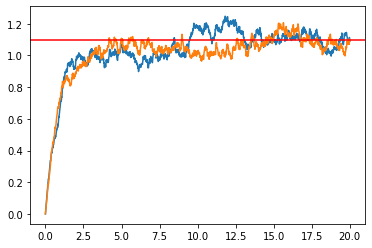

In [155]:
total_time = delta*N
time_axis = np.linspace(0, total_time, N+1) # N+1 to account for r0
plt.plot(time_axis.tolist(), test_run_1)
plt.plot(time_axis.tolist(), test_run_2)
plt.axhline(y=1.1, color='r', linestyle='-')

# Estimation

In [156]:
def Residual_1(phi,data,gamma=1e-6):
    length = len(data)
    diff = data[1:length] - phi * data[0:length-1]
    RSS = np.power(diff,2)
    RSS = np.sum(RSS / np.abs(data[1:length]+gamma))
    return(RSS)

In [157]:
def CIR_OLS_estimator(data,x0=1,gamma=1e-6,delta=0.01):
    length = len(data)
    mean = np.mean(data)
    cen_data = sta_data - mean
    args = (cen_data,gamma)
    opt_res = opt.minimize(fun=Residual_1,x0=x0,args = args)
    est_phi = opt_res.x
    RSS = opt_res.fun
    est_sigmma = np.sqrt(opt_res.fun/length)
    #print('estimated phi = {}'.format(est_phi),end = '\n')
    est_a = (1-est_phi) / delta
    #print('estimated a = {}'.format(est_a),end = '\n')
    return(est_a)

In [158]:
def CIR_estimator(data,sta_point,x0=1,gamma=1e-6,delta=0.01):
    b = np.mean(data[sta_point:])
    
    unsta_data = data[:sta_point]
    est_a = CIR_OLS_estimator(unsta_data,x0 = x0,gamma = gamma,delta = delta)
    
    sta_data = data[sta_point:] - b
    phi = est_a
    residual = Residual_1(phi,sta_data,gamma=1e-6)
    est_sigmma = np.sqrt(residual/(len(sta_data)-1))
    
    print('a = {},  b = {},  gamma = {}'.format(est_a,b,est_sigmma))
    
    return(est_a,b,est_sigmma,delta)

In [159]:
parameters = CIR_estimator(test_run_1,sta_point = 500)

a = [1.01087221],  b = 1.0861157361603317,  gamma = 0.08727188415177212


# Prediction
  
$r_t = r_{t-1}+a(b - r_{t-1})dt+\sigma \sqrt {r_{t-1}} \sqrt {dt} e_t$

In [160]:
def CIR_predictor_step(data,parameters,conf = 0.95):
    a,b,sigma,delta= parameters
    rt = data + a*(b-data)*delta
    volation = sigma*np.sqrt(data*delta)
    conf_interval = (volation * st.norm.ppf(1-conf,0,1),volation * st.norm.ppf(conf,0,1)) + rt
    return(rt,conf_interval)

In [161]:
return_list = CIR_predictor_step(test_run_1[-1],parameters,conf = 0.95)

In [162]:
rt = return_list[0]
conf_interval = return_list[1]
print('point_estimation = {} with 95% confident interval ({},{})'.format(rt,conf_interval[0],conf_interval[1]))

point_estimation = [1.08995992] with 95% confident interval (1.0749729254159779,1.1049469245652142)
